## TUIA - Aprendizaje Automático 1

### Trabajo Práctico: Predicción de lluvia en Australia.

### Integrantes:
- Ponce, Daniel
- Yañez, Mirian



El presente informe detalla el trabajo práctico llevado a cabo para la predicción de las condiciones climáticas en Australia, centrándonos en las ciudades de Adelaide, Canberra, Cobar, Dartmoor, Melbourne, MelbourneAirport, MountGambier, Sydney y SydneyAirport. 

El conjunto de datos utilizado se denomina weatherAUS.csv y contiene información climática de los últimos diez años.

## Variables de Interés:

**RainTomorrow y RainfallTomorrow**: Estas variables representan nuestro objetivo de predicción, indicando si lloverá al día siguiente y la cantidad de lluvia, respectivamente.

"RainTomorrow" (categórica, para un problema de clasificación)

"RainfallTomorrow" (continua, para un problema de regresión).

## Paquetes y Librerias

In [1]:
!pip install pandas scikit-learn seaborn imblearn



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import SGDRegressor, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier, DummyRegressor

import warnings
warnings.filterwarnings("ignore")

## Importar el dataset

In [3]:
file_path= 'weatherAUS.csv'
df = pd.read_csv(file_path, sep=',')

## Filtramos por las ciudades de interés y convertimos a formato date la fecha


In [4]:
ciudades = ['Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']
df = df[df['Location'].isin(ciudades)]
df['Date'] = pd.to_datetime(df['Date'])

## Visualizamos la distribución de los datos por año

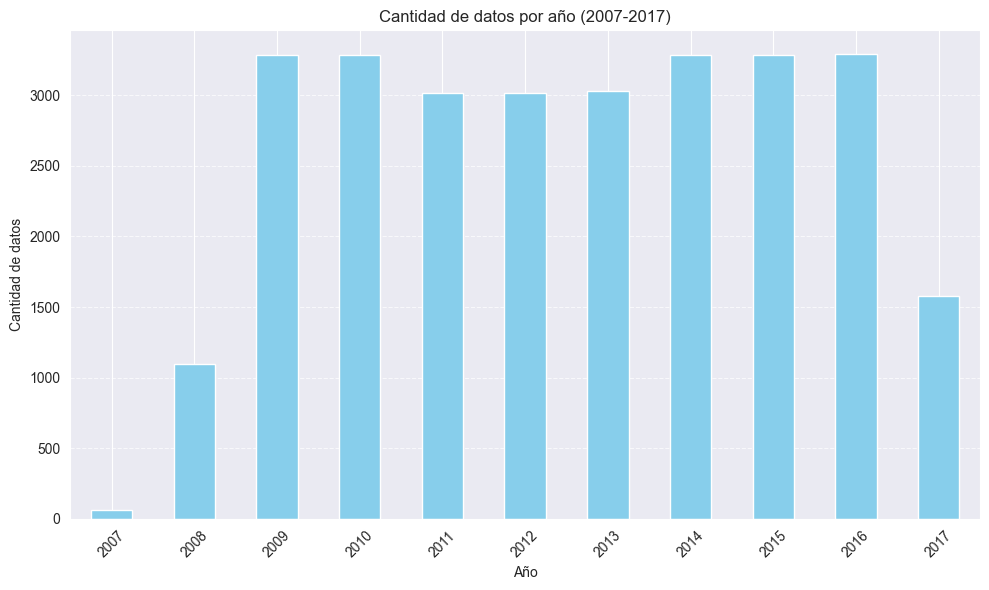

In [5]:
df['Year'] = pd.to_datetime(df['Date']).dt.year # Creamos la columna Year para poder realizar la visualización por año

# Contamos la cantidad de datos por año
data_by_year = df['Year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
data_by_year.plot(kind='bar', color='skyblue')
plt.title('Cantidad de datos por año (2007-2017)')
plt.xlabel('Año')
plt.ylabel('Cantidad de datos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
df = df.drop(columns=['Year']) # Eliminamos la columna Year

## Realizamos el split de entrenamiento y prueba 

Decidimos dividir el conjunto de datos de forma manual. Esta elección se debe a que posteriormente imputaremos los valores basados en la fecha. Si utilizáramos la función train_test_split, la separación sería aleatoria, lo que podría provocar una fuga de datos.


In [6]:
# Definimos las fechas límite para la división
date_train_limit = pd.to_datetime('2015-10-06')

# Filtramos el DataFrame para obtener los conjuntos de entrenamiento y prueba
train = df[df['Date'] <= date_train_limit]
test = df[df['Date'] > date_train_limit]

print(f"El conjunto de entrenamiento tiene {len(train)} registros y va hasta la fecha {date_train_limit}.")
print(f"El conjunto de prueba tiene {len(test)} registros y empieza a partir de la fecha {date_train_limit}.")

El conjunto de entrenamiento tiene 22590 registros y va hasta la fecha 2015-10-06 00:00:00.
El conjunto de prueba tiene 5643 registros y empieza a partir de la fecha 2015-10-06 00:00:00.


## Análisis descriptivo

Se realizará un análisis exploratorio del conjunto de datos de entrenamiento para entender sus características principales y determinar si se requiere alguna acción para abordar datos faltantes, valores atípicos, la codificación de variables categóricas u otros procesos antes de proceder.

In [7]:
train.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [8]:
train.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
6047,6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,0.0
6048,6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,0.0
6049,6051,2009-01-03,Cobar,15.5,34.1,0.0,12.6,13.3,SE,30.0,...,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,No,No,0.0
6050,6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,0.0
6051,6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,0.0


In [9]:
train.info()
train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 22590 entries, 6047 to 101892
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        22590 non-null  int64         
 1   Date              22590 non-null  datetime64[ns]
 2   Location          22590 non-null  object        
 3   MinTemp           22233 non-null  float64       
 4   MaxTemp           22246 non-null  float64       
 5   Rainfall          21848 non-null  float64       
 6   Evaporation       20574 non-null  float64       
 7   Sunshine          18628 non-null  float64       
 8   WindGustDir       21019 non-null  object        
 9   WindGustSpeed     21022 non-null  float64       
 10  WindDir9am        21175 non-null  object        
 11  WindDir3pm        22176 non-null  object        
 12  WindSpeed9am      22240 non-null  float64       
 13  WindSpeed3pm      22254 non-null  float64       
 14  Humidity9am       21985

Unnamed: 0             0
Date                   0
Location               0
MinTemp              357
MaxTemp              344
Rainfall             742
Evaporation         2016
Sunshine            3962
WindGustDir         1571
WindGustSpeed       1568
WindDir9am          1415
WindDir3pm           414
WindSpeed9am         350
WindSpeed3pm         336
Humidity9am          605
Humidity3pm          561
Pressure9am          625
Pressure3pm          618
Cloud9am            7179
Cloud3pm            7469
Temp9am              372
Temp3pm              366
RainToday            742
RainTomorrow         742
RainfallTomorrow     742
dtype: int64

### **Hay un total de 22590 datos de entrenamiento, 25 columnas y se puede observar que hay datos nulos en la mayoria de las variables.**

### Eliminamos la columna 'Unnamed: 0' y 'Location'
Eliminamos la columna Location ya que vamos a considerarlas a todas como una sola

In [10]:
train = train.drop(columns=['Unnamed: 0', 'Location'])

### Cambiamos los valores nulos
Debido a que tomamos las ciudades como una única localidad, decidimos reemplazar los valores faltantes por otro de la misma fecha o, en su defecto por la mas cercana.

In [11]:
train.sort_values(by='Date', inplace=True)
train.fillna(method='ffill', inplace=True)

In [12]:
train.isna().sum()

Date                0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
RainfallTomorrow    0
dtype: int64

### Eliminamos la columna Date:
La razon es que ya no la vamos a usar, solo la usamos como criterio para el reemplazo de los valores nulos

In [13]:
train = train.drop(columns=['Date'])

In [14]:
train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

## Creación de columnas 
Con el objetivo de reducir la cantidad de columnas y mejorar la explicabilidad del modelo, decidimos agrupar las variables que representan dos momentos del día en una sola columna.

In [15]:
columns_to_aggregate = ['Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'Humidity9am', 
                        'Humidity3pm', 'Cloud9am', 'Cloud3pm','WindSpeed3pm','WindSpeed9am']
new_columns = []
train['PressureVariation'] = train['Pressure3pm'] - train['Pressure9am']
train['TempVariation'] = train['Temp3pm'] - train['Temp9am']
train['HumidityVariation'] = train['Humidity3pm'] - train['Humidity9am']
train['CloudVariation'] = train['Cloud3pm'] - train['Cloud9am']
train['WindSpeedVariation'] = train['WindSpeed3pm'] - train['WindSpeed9am']
train.drop(columns=columns_to_aggregate, inplace=True)


In [16]:
train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'RainToday',
       'RainTomorrow', 'RainfallTomorrow', 'PressureVariation',
       'TempVariation', 'HumidityVariation', 'CloudVariation',
       'WindSpeedVariation'],
      dtype='object')

### Estadística descriptiva de las variables numéricas
Examinamos medidas estadísticas, incluyendo valores mínimos, máximos, cuartiles, y medidas de centralidad como la mediana y la media.

In [17]:
train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,RainfallTomorrow,PressureVariation,TempVariation,HumidityVariation,CloudVariation,WindSpeedVariation
count,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000,22590.00000
mean,11.064692,21.630885,2.025507,4.680704,6.854635,42.176007,2.014697,-2.102732,4.909491,-18.350686,0.100531,4.87490
std,5.691401,6.608799,6.345521,3.582461,3.852589,14.325702,6.271540,2.107172,3.417628,15.730870,2.621864,9.04668
min,-8.000000,4.100000,0.000000,0.000000,0.000000,11.000000,0.000000,-13.400000,-10.100000,-82.000000,-8.000000,-46.00000
25%,7.300000,16.400000,0.000000,2.200000,3.800000,31.000000,0.000000,-3.500000,2.600000,-28.000000,-1.000000,0.00000
50%,10.700000,20.700000,0.000000,4.000000,7.300000,41.000000,0.000000,-2.300000,4.600000,-18.000000,0.000000,5.00000
75%,14.900000,25.800000,1.000000,6.400000,10.000000,50.000000,1.000000,-0.900000,7.100000,-9.000000,1.000000,11.00000
max,33.900000,46.800000,119.400000,64.800000,14.300000,122.000000,119.400000,12.600000,23.000000,76.000000,8.000000,52.00000


Al analizar las columnas, se percibe que tanto la media como la mediana muestran una cercanía notable, lo que sugiere una tendencia consistente en los datos. Los desvíos en la dispersión de los datos no son extremos y la distribución no presentaria una gran extensión en un boxplot.

Los valores mínimos y máximos registrados estan considerablemente alejados de los valores centrales, lo cual señala la posible existencia de valores atípicos dentro del conjunto de datos.

## **Bloxplot**

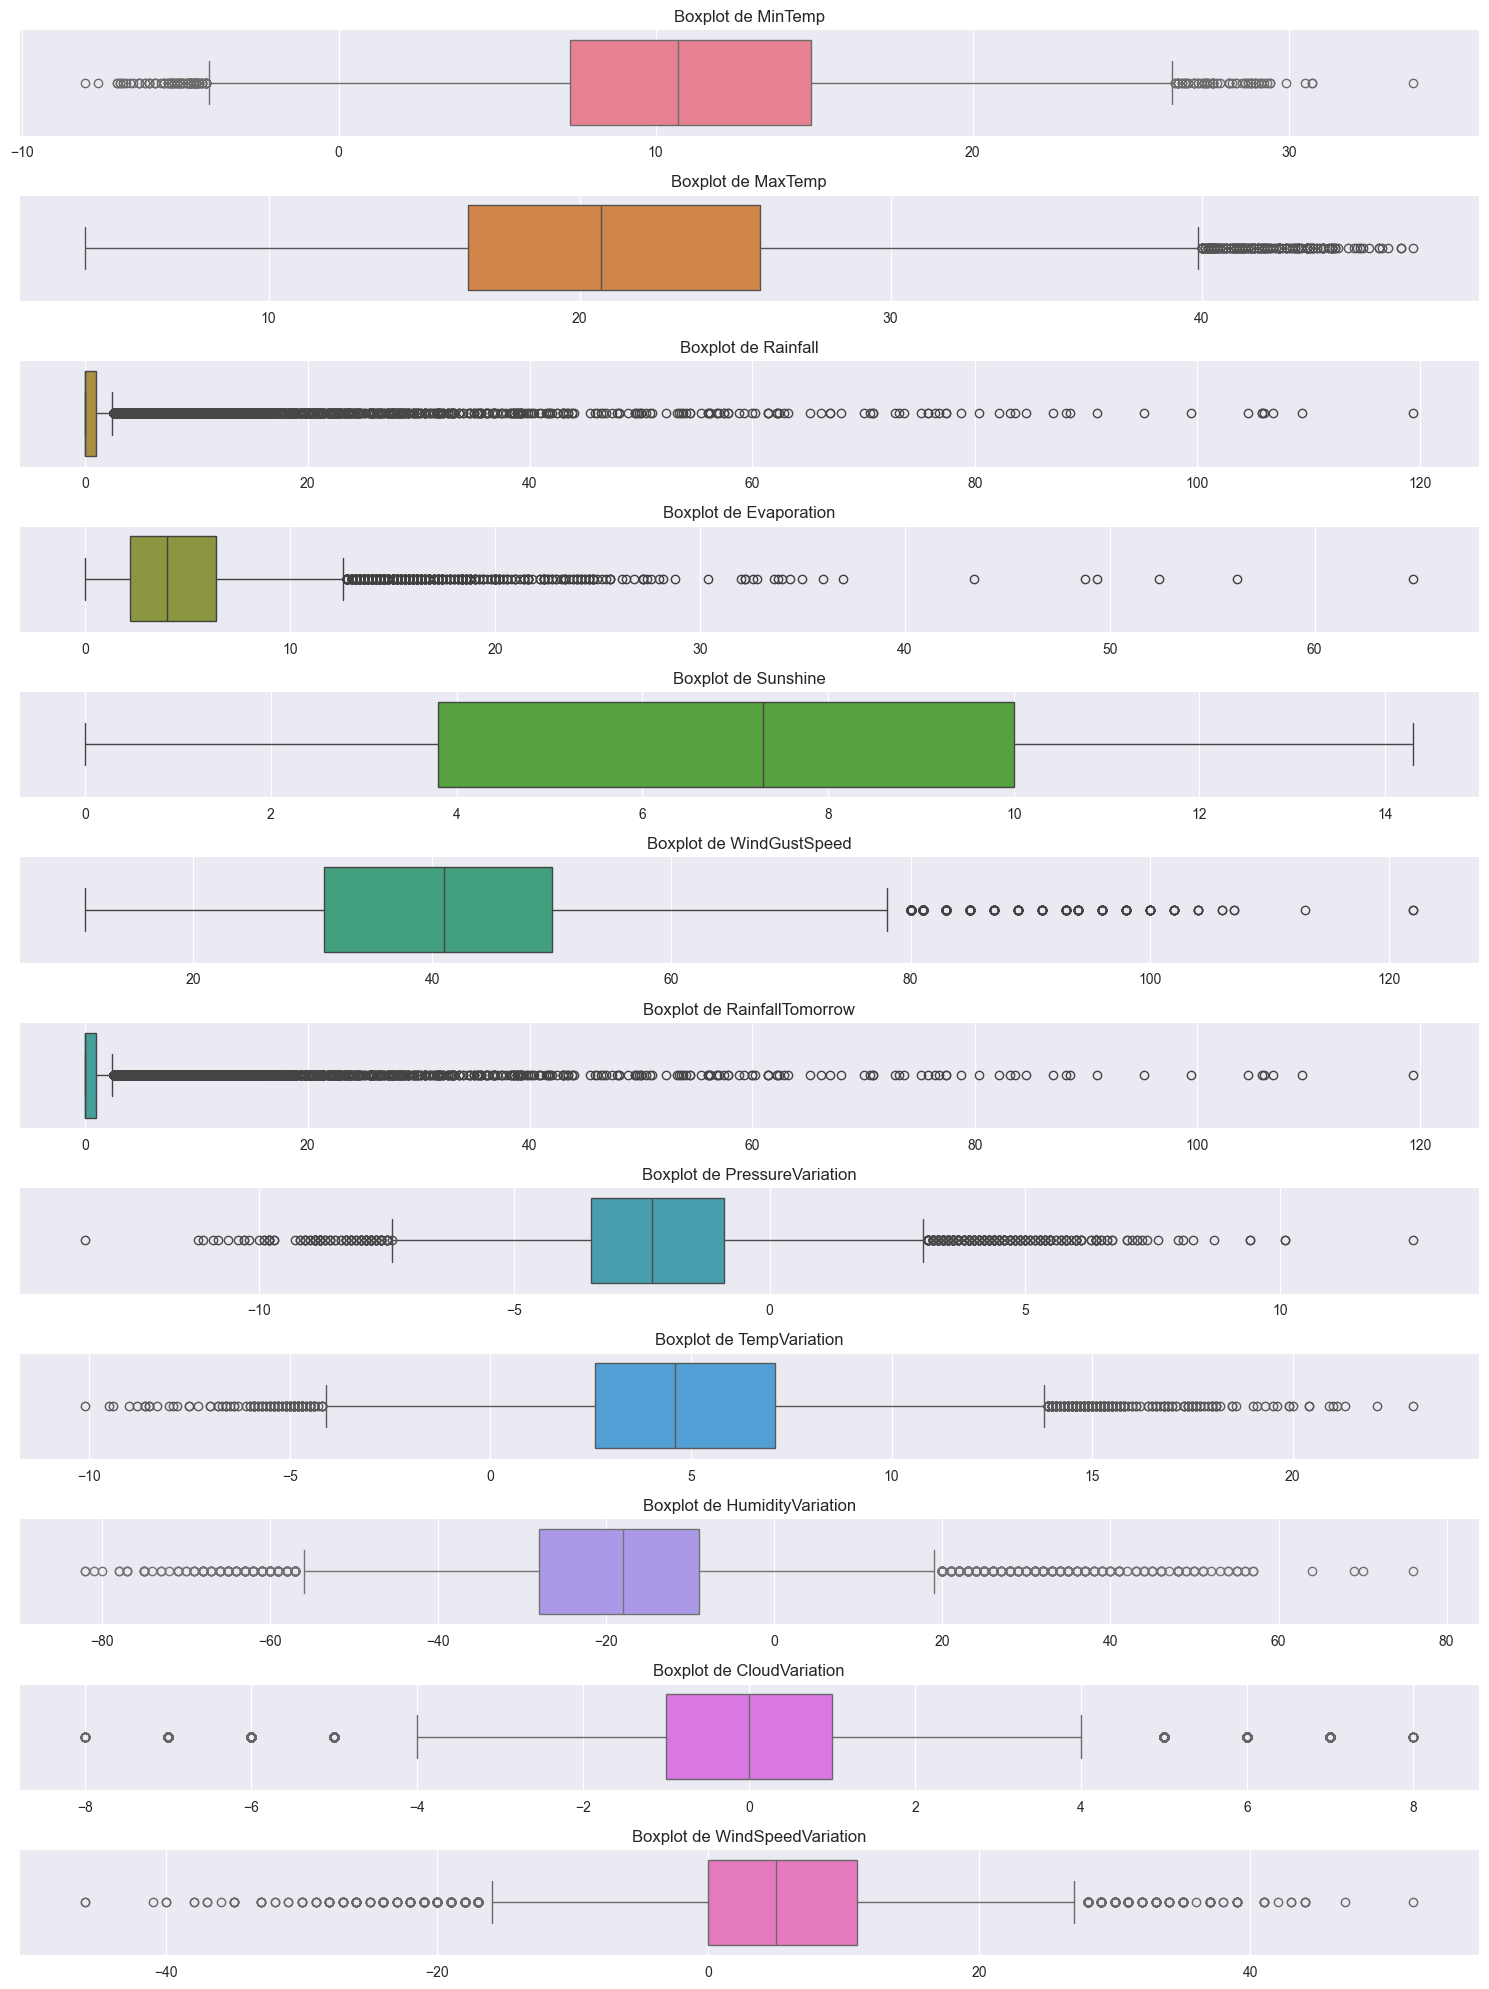

In [18]:
numeric_columns = train.select_dtypes(include=[np.float64]).columns

colores = sns.color_palette('husl', n_colors=len(numeric_columns))

fig, axes = plt.subplots(len(numeric_columns), 1, figsize=(15, 20), sharex=False)

for i, col in enumerate(numeric_columns):
    sns.boxplot(data=train, x=col, ax=axes[i], color=colores[i], orient='h')
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_xlabel('')

plt.tight_layout()

plt.show()

## Histograma

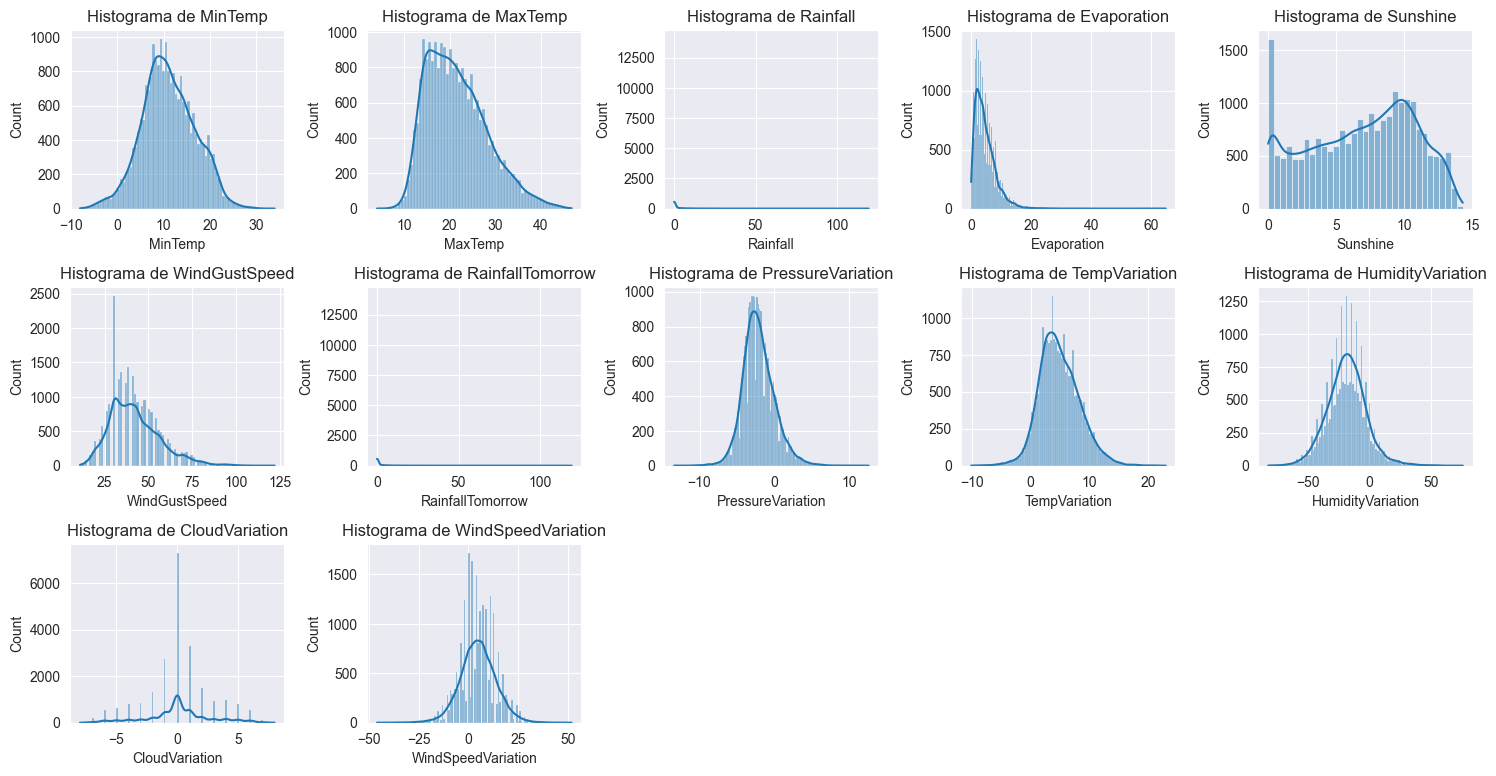

In [19]:
numeric_columns = train.select_dtypes(include=[np.float64]).columns

plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 5, i)
    sns.histplot(train[column].dropna(), kde=True)
    plt.title(f'Histograma de {column}')

plt.tight_layout()
plt.show()

Para comprender más a fondo el comportamiento de los datos, empleamos histogramas donde se puede apreciar que algunas variables exhiben una distribución más uniforme de sus valores, como es el caso de la temperatura, humedad y presión. Por otro lado, existen variables que muestran la presencia de múltiples modas en los datos y una distribución menos uniforme.

Asimismo, se destaca que la variable Rainfall concentra la gran mayoría de sus datos en cero.

## Analizamos nuestra variable objetivo, la que queremos predecir para saber si el dataset esta balanceado o no.
Primero convertimos las variables categóricas en numéricas

In [20]:
train['RainToday'] = train['RainToday'].map({'No': 0, 'Yes': 1})
train['RainTomorrow'] = train['RainTomorrow'].map({'No': 0, 'Yes': 1})

test['RainToday'] = test['RainToday'].map({'No': 0, 'Yes': 1})
test['RainTomorrow'] = test['RainTomorrow'].map({'No': 0, 'Yes': 1})

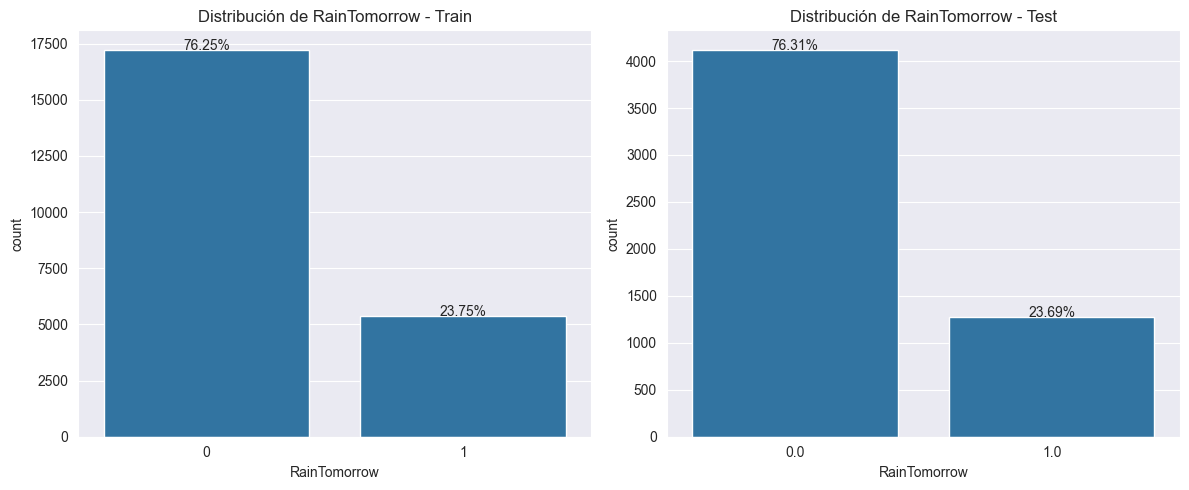

In [21]:
# Calculamos los porcentajes para el conjunto de entrenamiento
train_percentages = train['RainTomorrow'].value_counts(normalize=True) * 100
# Calculamos los porcentajes para el conjunto de prueba
test_percentages = test['RainTomorrow'].value_counts(normalize=True) * 100

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='RainTomorrow', data=train)
plt.title('Distribución de RainTomorrow - Train')
for i, value in enumerate(train_percentages):
    plt.text(i, train['RainTomorrow'].value_counts()[i], f'{value:.2f}%', ha='center')

plt.subplot(1, 2, 2)
sns.countplot(x='RainTomorrow', data=test)
plt.title('Distribución de RainTomorrow - Test')
for i, value in enumerate(test_percentages):
    plt.text(i, test['RainTomorrow'].value_counts()[i], f'{value:.2f}%', ha='center')

plt.tight_layout()
plt.show()


### Se observa que tanto en el conjuntos de entrenamiento como en el de prueba hay una mayor cantidad de datos donde no llueve (0) comparado con los días que llueve (1). Esto puede hacer que el modelo tenga un sesgo muy importante al momento de predecir. Por esta razón, podemos decir que los datos no se encuentran balanceados.
### Podemos ver una relacion 3 a 1 aproximadamente, en este caso existe la posibilidad de balancear el dataset.

# Matriz de correlación 

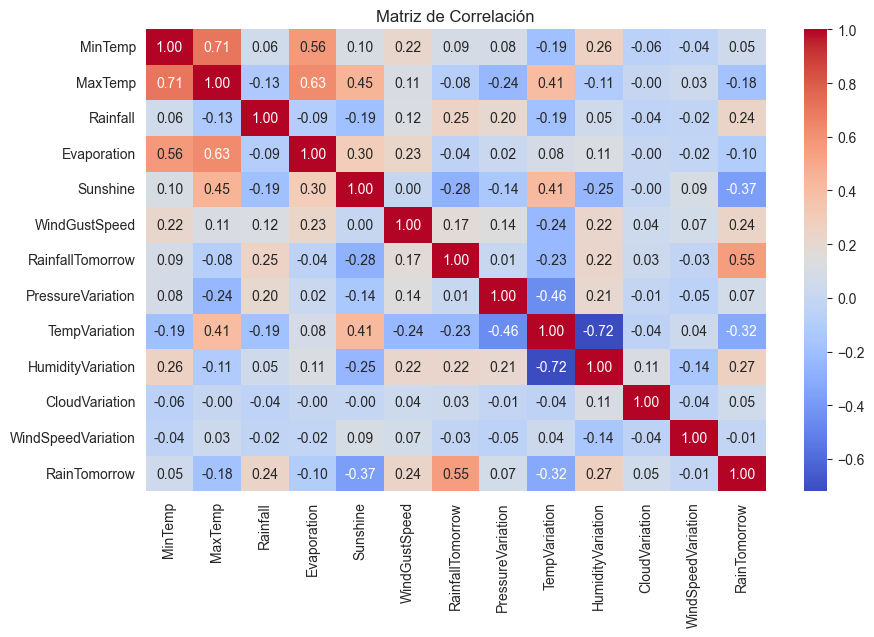

In [22]:
numeric_columns = numeric_columns.append(pd.Index(['RainTomorrow']))
correlation_matrix_numeric = train[numeric_columns].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

Podemos observar que las variables con mayor correlación positiva con RainfallTomorrow son:

*   Rainfall (0.25)
*   HumidityVariation (0.22)
*   WindGustSpeed (0.17)

Las variables con mayor correlación negativa con RainfallTomorrow son:
*   Sunshine (-0.28)
*   TempVariation (-0.23)

Las variables con mayor correlación positiva con RainTomorrow son:

*   RainfallTomorrow (0.55)
*   HumidityVariation (0,27)
*   Rainfall (0.24)
*   WindGustSpeed (0,24)

Las variables con mayor correlación negativa con RainTomorrow son:
*   Sunshine (-0.37)
*   TempVariation (-0.32)

## Para poder ver las metricas de test necesitamos aplicarle los mismos cambios que se hicieron en train.

In [23]:
test.sort_values(by='Date', inplace=True)

for column in test.columns:
    test[column] = test[column].ffill()
    test[column] = test[column].bfill() 
    
columns_to_aggregate = ['Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'Humidity9am', 
                        'Humidity3pm', 'Cloud9am', 'Cloud3pm','WindSpeed3pm','WindSpeed9am']
new_columns = []
test = test.drop(columns=['Unnamed: 0', 'Location','Date'])
test['PressureVariation'] = test['Pressure3pm'] - test['Pressure9am']
test['TempVariation'] = test['Temp3pm'] - test['Temp9am']
test['HumidityVariation'] = test['Humidity3pm'] - test['Humidity9am']
test['CloudVariation'] = test['Cloud3pm'] - test['Cloud9am']
test['WindSpeedVariation'] = test['WindSpeed3pm'] - test['WindSpeed9am']
test.drop(columns=columns_to_aggregate, inplace=True)


# Método LinearRegression

Evaluamos el modelo con los datos de entrenamiento y luego con los de test

In [24]:
# Seleccionar las variables predictoras (características) y la variable de respuesta (y) para ambos conjuntos
X_train = train.drop(['RainfallTomorrow','WindGustDir','WindDir9am','WindDir3pm','RainTomorrow'], axis=1)
y_train = train['RainfallTomorrow']
X_test = test.drop(['RainfallTomorrow','WindGustDir','WindDir9am','WindDir3pm','RainTomorrow'], axis=1)
y_test = test['RainfallTomorrow']

# Entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Hacer predicciones sobre los datos de entrenamiento y de prueba
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calcular métricas sobre los datos de entrenamiento
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

# Calcular métricas sobre los datos de prueba
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Imprimir las métricas
print("Métricas sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train)
print("R-squared (Train):", r2_train)
print("Mean Absolute Error (MAE) (Train):", mae_train)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train)

print("\nMétricas sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test)
print("R-squared (Test):", r2_test)
print("Mean Absolute Error (MAE) (Test):", mae_test)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test)


Métricas sobre los datos de entrenamiento:
Mean Squared Error (Train): 32.484210295678466
R-squared (Train): 0.17407014355216888
Mean Absolute Error (MAE) (Train): 2.709652372140679
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas sobre los datos de prueba:
Mean Squared Error (Test): 36.17660183183071
R-squared (Test): 0.19001379327801093
Mean Absolute Error (MAE) (Test): 2.873185219925162
Mean Absolute Percentage Error (MAPE) (Test): inf


### No se observa presencia de overfiting, podemos notar que las metricas de train y test son bastante similares

# Método de gradiente descendiente

In [25]:
sgd_model = SGDRegressor(loss='squared_error', max_iter=3000, random_state=42)
sgd_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_train = sgd_model.predict(X_train)
y_pred_test = sgd_model.predict(X_test)

# Calcular métricas
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Imprimir las métricas
print("Métricas sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train)
print("R-squared (Train):", r2_train)
print("Mean Absolute Error (MAE) (Train):", mae_train)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train)

print("\nMétricas sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test)
print("R-squared (Test):", r2_test)
print("Mean Absolute Error (MAE) (Test):", mae_test)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test)

Métricas sobre los datos de entrenamiento:
Mean Squared Error (Train): 59.20292691279697
R-squared (Train): -0.5052686976627199
Mean Absolute Error (MAE) (Train): 5.020427038040169
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas sobre los datos de prueba:
Mean Squared Error (Test): 62.54410981933758
R-squared (Test): -0.4003489465612178
Mean Absolute Error (MAE) (Test): 5.02570765048396
Mean Absolute Percentage Error (MAPE) (Test): inf


Notamos en este método, que las métricas de r2 comparadas con la regresión lineal son peores.

# Métodos de regularización Lasso

In [26]:
# Crear y entrenar el modelo Lasso
lasso_model = Lasso(alpha=0.1)  # alpha es el parámetro de regularización
lasso_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_train = lasso_model.predict(X_train)
y_pred_test = lasso_model.predict(X_test)

# Calcular métricas
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Imprimir las métricas
print("Métricas sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train)
print("R-squared (Train):", r2_train)
print("Mean Absolute Error (MAE) (Train):", mae_train)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train)

print("\nMétricas sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test)
print("R-squared (Test):", r2_test)
print("Mean Absolute Error (MAE) (Test):", mae_test)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test)


Métricas sobre los datos de entrenamiento:
Mean Squared Error (Train): 32.577677923006256
R-squared (Train): 0.17169367500579835
Mean Absolute Error (MAE) (Train): 2.6841392709554635
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas sobre los datos de prueba:
Mean Squared Error (Test): 36.236966129405815
R-squared (Test): 0.18866224985108582
Mean Absolute Error (MAE) (Test): 2.851720280775242
Mean Absolute Percentage Error (MAPE) (Test): inf


## Lasso con validación cruzada

In [27]:
from sklearn.linear_model import LassoCV

# Crea una instancia de LassoCV
lasso_cv_model = LassoCV(cv=5)  # Número de divisiones de validación cruzada

# Entrena el modelo
lasso_cv_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_train_cv = lasso_cv_model.predict(X_train)
y_pred_test_cv = lasso_cv_model.predict(X_test)

# Calcular métricas
mse_train_cv = mean_squared_error(y_train, y_pred_train_cv)
r2_train_cv = r2_score(y_train, y_pred_train_cv)
mae_train_cv = mean_absolute_error(y_train, y_pred_train_cv)
mape_train_cv = np.mean(np.abs((y_train - y_pred_train_cv) / y_train)) * 100

mse_test_cv = mean_squared_error(y_test, y_pred_test_cv)
r2_test_cv = r2_score(y_test, y_pred_test_cv)
mae_test_cv = mean_absolute_error(y_test, y_pred_test_cv)
mape_test_cv = np.mean(np.abs((y_test - y_pred_test_cv) / y_test)) * 100

# Imprimir las métricas
print("Métricas con LassoCV sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train_cv)
print("R-squared (Train):", r2_train_cv)
print("Mean Absolute Error (MAE) (Train):", mae_train_cv)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train_cv)

print("\nMétricas con LassoCV sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test_cv)
print("R-squared (Test):", r2_test_cv)
print("Mean Absolute Error (MAE) (Test):", mae_test_cv)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test_cv)


Métricas con LassoCV sobre los datos de entrenamiento:
Mean Squared Error (Train): 32.48868077378031
R-squared (Train): 0.17395647905784062
Mean Absolute Error (MAE) (Train): 2.7021891982642523
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas con LassoCV sobre los datos de prueba:
Mean Squared Error (Test): 36.17344159214588
R-squared (Test): 0.1900845503537183
Mean Absolute Error (MAE) (Test): 2.866700651126048
Mean Absolute Percentage Error (MAPE) (Test): inf


## Lasso con random_search

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
from scipy.stats import uniform

# Define los rangos de valores para los hiperparámetros que quieres explorar
param_distributions = {
    'alpha': uniform(0.1, 100.0),  # Rango uniforme entre 0.1 y 100.0 para alpha
}

# Crea una instancia del modelo Lasso
lasso_model = Lasso()

# Crea una instancia de RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=lasso_model, 
                                   param_distributions=param_distributions, 
                                   n_iter=10,  # Número de iteraciones de búsqueda aleatoria
                                   scoring='neg_mean_squared_error',  # Métrica de evaluación
                                   cv=5,  # Número de divisiones de validación cruzada
                                   random_state=42)

# Entrena el modelo usando RandomizedSearchCV
random_search.fit(X_train, y_train)

# Muestra los mejores parámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Hacer predicciones con el mejor modelo encontrado
y_pred_train_rs = random_search.predict(X_train)
y_pred_test_rs = random_search.predict(X_test)

# Calcular métricas
mse_train_rs = mean_squared_error(y_train, y_pred_train_rs)
r2_train_rs = r2_score(y_train, y_pred_train_rs)
mae_train_rs = mean_absolute_error(y_train, y_pred_train_rs)
mape_train_rs = np.mean(np.abs((y_train - y_pred_train_rs) / y_train)) * 100

mse_test_rs = mean_squared_error(y_test, y_pred_test_rs)
r2_test_rs = r2_score(y_test, y_pred_test_rs)
mae_test_rs = mean_absolute_error(y_test, y_pred_test_rs)
mape_test_rs = np.mean(np.abs((y_test - y_pred_test_rs) / y_test)) * 100

# Imprimir las métricas
print("\nMétricas con RandomizedSearchCV sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train_rs)
print("R-squared (Train):", r2_train_rs)
print("Mean Absolute Error (MAE) (Train):", mae_train_rs)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train_rs)

print("\nMétricas con RandomizedSearchCV sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test_rs)
print("R-squared (Test):", r2_test_rs)
print("Mean Absolute Error (MAE) (Test):", mae_test_rs)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test_rs)


Mejores hiperparámetros encontrados:
{'alpha': 5.908361216819946}

Métricas con RandomizedSearchCV sobre los datos de entrenamiento:
Mean Squared Error (Train): 35.75856344750023
R-squared (Train): 0.09081781868332539
Mean Absolute Error (MAE) (Train): 2.7355111060225568
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas con RandomizedSearchCV sobre los datos de prueba:
Mean Squared Error (Test): 39.86969418785708
R-squared (Test): 0.10732626274550605
Mean Absolute Error (MAE) (Test): 2.856887011349184
Mean Absolute Percentage Error (MAPE) (Test): inf


## Lasso con grid_search

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

# Define los valores de los hiperparámetros que quieres explorar
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]  # Lista de valores para alpha
}

# Crea una instancia del modelo Lasso
lasso_model = Lasso()

# Crea una instancia de GridSearchCV
grid_search = GridSearchCV(estimator=lasso_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error',  # Métrica de evaluación
                           cv=5)  # Número de divisiones de validación cruzada

# Entrena el modelo usando GridSearchCV
grid_search.fit(X_train, y_train)

# Muestra los mejores parámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Hacer predicciones con el mejor modelo encontrado
y_pred_train_gs = grid_search.predict(X_train)
y_pred_test_gs = grid_search.predict(X_test)

# Calcular métricas
mse_train_gs = mean_squared_error(y_train, y_pred_train_gs)
r2_train_gs = r2_score(y_train, y_pred_train_gs)
mae_train_gs = mean_absolute_error(y_train, y_pred_train_gs)
mape_train_gs = np.mean(np.abs((y_train - y_pred_train_gs) / y_train)) * 100

mse_test_gs = mean_squared_error(y_test, y_pred_test_gs)
r2_test_gs = r2_score(y_test, y_pred_test_gs)
mae_test_gs = mean_absolute_error(y_test, y_pred_test_gs)
mape_test_gs = np.mean(np.abs((y_test - y_pred_test_gs) / y_test)) * 100

# Imprimir las métricas
print("\nMétricas con GridSearchCV sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train_gs)
print("R-squared (Train):", r2_train_gs)
print("Mean Absolute Error (MAE) (Train):", mae_train_gs)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train_gs)

print("\nMétricas con GridSearchCV sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test_gs)
print("R-squared (Test):", r2_test_gs)
print("Mean Absolute Error (MAE) (Test):", mae_test_gs)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test_gs)


Mejores hiperparámetros encontrados:
{'alpha': 0.1}

Métricas con GridSearchCV sobre los datos de entrenamiento:
Mean Squared Error (Train): 32.577677923006256
R-squared (Train): 0.17169367500579835
Mean Absolute Error (MAE) (Train): 2.6841392709554635
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas con GridSearchCV sobre los datos de prueba:
Mean Squared Error (Test): 36.236966129405815
R-squared (Test): 0.18866224985108582
Mean Absolute Error (MAE) (Test): 2.851720280775242
Mean Absolute Percentage Error (MAPE) (Test): inf


# Regresión de Ridge

In [30]:
# Crear y entrenar el modelo Ridge
ridge_model = Ridge(alpha=0.1)  # alpha es el parámetro de regularización
ridge_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_train = ridge_model.predict(X_train)
y_pred_test = ridge_model.predict(X_test)

# Calcular métricas
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Imprimir las métricas
print("Métricas sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train)
print("R-squared (Train):", r2_train)
print("Mean Absolute Error (MAE) (Train):", mae_train)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train)

print("\nMétricas sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test)
print("R-squared (Test):", r2_test)
print("Mean Absolute Error (MAE) (Test):", mae_test)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test)


Métricas sobre los datos de entrenamiento:
Mean Squared Error (Train): 32.484210295866944
R-squared (Train): 0.1740701435473766
Mean Absolute Error (MAE) (Train): 2.7096513790655705
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas sobre los datos de prueba:
Mean Squared Error (Test): 36.176598792766534
R-squared (Test): 0.1900138613219935
Mean Absolute Error (MAE) (Test): 2.87318434849543
Mean Absolute Percentage Error (MAPE) (Test): inf


## Ridge con validación cruzada

In [31]:
from sklearn.linear_model import RidgeCV

# Define una lista de valores de alphas que quieres probar
alphas = [0.001, 0.1, 0.3, 0.5, 0.8, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]  # Puedes ajustar esta lista según sea necesario

# Crea una instancia de RidgeCV y pasa los valores de alphas
ridge_cv_model = RidgeCV(alphas=alphas)

# Entrena el modelo
ridge_cv_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_train_cv = ridge_cv_model.predict(X_train)
y_pred_test_cv = ridge_cv_model.predict(X_test)

# Calcular métricas
mse_train_cv = mean_squared_error(y_train, y_pred_train_cv)
r2_train_cv = r2_score(y_train, y_pred_train_cv)
mae_train_cv = mean_absolute_error(y_train, y_pred_train_cv)
mape_train_cv = np.mean(np.abs((y_train - y_pred_train_cv) / y_train)) * 100

mse_test_cv = mean_squared_error(y_test, y_pred_test_cv)
r2_test_cv = r2_score(y_test, y_pred_test_cv)
mae_test_cv = mean_absolute_error(y_test, y_pred_test_cv)
mape_test_cv = np.mean(np.abs((y_test - y_pred_test_cv) / y_test)) * 100

# Imprimir las métricas
print("Métricas con RidgeCV sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train_cv)
print("R-squared (Train):", r2_train_cv)
print("Mean Absolute Error (MAE) (Train):", mae_train_cv)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train_cv)

print("\nMétricas con RidgeCV sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test_cv)
print("R-squared (Test):", r2_test_cv)
print("Mean Absolute Error (MAE) (Test):", mae_test_cv)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test_cv)


Métricas con RidgeCV sobre los datos de entrenamiento:
Mean Squared Error (Train): 32.484212165211936
R-squared (Train): 0.1740700960181979
Mean Absolute Error (MAE) (Train): 2.7095538392558747
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas con RidgeCV sobre los datos de prueba:
Mean Squared Error (Test): 36.17630129410396
R-squared (Test): 0.1900205222520146
Mean Absolute Error (MAE) (Test): 2.8730983622661626
Mean Absolute Percentage Error (MAPE) (Test): inf


## Ridge con random_search

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
from scipy.stats import uniform

# Define los rangos de valores para los hiperparámetros que quieres explorar
param_distributions = {
    'alpha': uniform(0.1, 100.0),  # Rango uniforme entre 0.1 y 100.0 para alpha
}

# Crea una instancia del modelo Ridge
ridge_model = Ridge()

# Crea una instancia de RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=ridge_model, 
                                   param_distributions=param_distributions, 
                                   n_iter=10,  # Número de iteraciones de búsqueda aleatoria
                                   scoring='neg_mean_squared_error',  # Métrica de evaluación
                                   cv=5,  # Número de divisiones de validación cruzada
                                   random_state=42)

# Entrena el modelo usando RandomizedSearchCV
random_search.fit(X_train, y_train)

# Muestra los mejores parámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Hacer predicciones con el mejor modelo encontrado
y_pred_train_rs = random_search.predict(X_train)
y_pred_test_rs = random_search.predict(X_test)

# Calcular métricas
mse_train_rs = mean_squared_error(y_train, y_pred_train_rs)
r2_train_rs = r2_score(y_train, y_pred_train_rs)
mae_train_rs = mean_absolute_error(y_train, y_pred_train_rs)
mape_train_rs = np.mean(np.abs((y_train - y_pred_train_rs) / y_train)) * 100

mse_test_rs = mean_squared_error(y_test, y_pred_test_rs)
r2_test_rs = r2_score(y_test, y_pred_test_rs)
mae_test_rs = mean_absolute_error(y_test, y_pred_test_rs)
mape_test_rs = np.mean(np.abs((y_test - y_pred_test_rs) / y_test)) * 100

# Imprimir las métricas
print("\nMétricas con RandomizedSearchCV sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train_rs)
print("R-squared (Train):", r2_train_rs)
print("Mean Absolute Error (MAE) (Train):", mae_train_rs)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train_rs)

print("\nMétricas con RandomizedSearchCV sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test_rs)
print("R-squared (Test):", r2_test_rs)
print("Mean Absolute Error (MAE) (Test):", mae_test_rs)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test_rs)


Mejores hiperparámetros encontrados:
{'alpha': 95.17143064099162}

Métricas con RandomizedSearchCV sobre los datos de entrenamiento:
Mean Squared Error (Train): 32.48436839835147
R-squared (Train): 0.17406612370015984
Mean Absolute Error (MAE) (Train): 2.7087606827451047
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas con RandomizedSearchCV sobre los datos de prueba:
Mean Squared Error (Test): 36.174001261611785
R-squared (Test): 0.1900720194767216
Mean Absolute Error (MAE) (Test): 2.8723913912338612
Mean Absolute Percentage Error (MAPE) (Test): inf


## Ridge con grid_search

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Define los valores de los hiperparámetros que quieres explorar
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]  # Lista de valores para alpha
}

# Crea una instancia del modelo Ridge
ridge_model = Ridge()

# Crea una instancia de GridSearchCV
grid_search = GridSearchCV(estimator=ridge_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error',  # Métrica de evaluación
                           cv=5)  # Número de divisiones de validación cruzada

# Entrena el modelo usando GridSearchCV
grid_search.fit(X_train, y_train)

# Muestra los mejores parámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Hacer predicciones con el mejor modelo encontrado
y_pred_train_gs = grid_search.predict(X_train)
y_pred_test_gs = grid_search.predict(X_test)

# Calcular métricas
mse_train_gs = mean_squared_error(y_train, y_pred_train_gs)
r2_train_gs = r2_score(y_train, y_pred_train_gs)
mae_train_gs = mean_absolute_error(y_train, y_pred_train_gs)
mape_train_gs = np.mean(np.abs((y_train - y_pred_train_gs) / y_train)) * 100

mse_test_gs = mean_squared_error(y_test, y_pred_test_gs)
r2_test_gs = r2_score(y_test, y_pred_test_gs)
mae_test_gs = mean_absolute_error(y_test, y_pred_test_gs)
mape_test_gs = np.mean(np.abs((y_test - y_pred_test_gs) / y_test)) * 100

# Imprimir las métricas
print("\nMétricas con GridSearchCV sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train_gs)
print("R-squared (Train):", r2_train_gs)
print("Mean Absolute Error (MAE) (Train):", mae_train_gs)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train_gs)

print("\nMétricas con GridSearchCV sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test_gs)
print("R-squared (Test):", r2_test_gs)
print("Mean Absolute Error (MAE) (Test):", mae_test_gs)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test_gs)


Mejores hiperparámetros encontrados:
{'alpha': 100.0}

Métricas con GridSearchCV sobre los datos de entrenamiento:
Mean Squared Error (Train): 32.48438418261483
R-squared (Train): 0.17406572237612417
Mean Absolute Error (MAE) (Train): 2.708717711722061
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas con GridSearchCV sobre los datos de prueba:
Mean Squared Error (Test): 36.17388392665332
R-squared (Test): 0.1900746465807921
Mean Absolute Error (MAE) (Test): 2.8723530567507116
Mean Absolute Percentage Error (MAPE) (Test): inf


## Método de regularización Elasticnet

In [34]:
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)  # alpha es el parámetro de regularización, l1_ratio controla la proporción de L1 y L2
elastic_net_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_train = elastic_net_model.predict(X_train)
y_pred_test = elastic_net_model.predict(X_test)

# Calcular métricas
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Imprimir las métricas
print("Métricas sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train)
print("R-squared (Train):", r2_train)
print("Mean Absolute Error (MAE) (Train):", mae_train)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train)

print("\nMétricas sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test)
print("R-squared (Test):", r2_test)
print("Mean Absolute Error (MAE) (Test):", mae_test)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test)

Métricas sobre los datos de entrenamiento:
Mean Squared Error (Train): 32.52922468326769
R-squared (Train): 0.17292562668254985
Mean Absolute Error (MAE) (Train): 2.691230016521275
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas sobre los datos de prueba:
Mean Squared Error (Test): 36.19482594263016
R-squared (Test): 0.18960575942104596
Mean Absolute Error (MAE) (Test): 2.85748342355517
Mean Absolute Percentage Error (MAPE) (Test): inf


## Elasticnet con validación cruzada

In [35]:
from sklearn.linear_model import ElasticNetCV

# Define una lista de valores de alphas que quieres probar
alphas = [0.001, 0.1, 0.3, 0.5, 0.8, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]  # Puedes ajustar esta lista según sea necesario

# Define una lista de valores de l1_ratio
l1_ratios = [0.1, 0.5, 0.9]  # Puedes ajustar esta lista según sea necesario

# Crea una instancia de ElasticNetCV y pasa los valores de alphas y l1_ratio
elastic_net_cv_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios)

# Entrena el modelo
elastic_net_cv_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_train_cv = elastic_net_cv_model.predict(X_train)
y_pred_test_cv = elastic_net_cv_model.predict(X_test)

# Calcular métricas
mse_train_cv = mean_squared_error(y_train, y_pred_train_cv)
r2_train_cv = r2_score(y_train, y_pred_train_cv)
mae_train_cv = mean_absolute_error(y_train, y_pred_train_cv)
mape_train_cv = np.mean(np.abs((y_train - y_pred_train_cv) / y_train)) * 100

mse_test_cv = mean_squared_error(y_test, y_pred_test_cv)
r2_test_cv = r2_score(y_test, y_pred_test_cv)
mae_test_cv = mean_absolute_error(y_test, y_pred_test_cv)
mape_test_cv = np.mean(np.abs((y_test - y_pred_test_cv) / y_test)) * 100

# Imprimir las métricas
print("Métricas con ElasticNetCV sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train_cv)
print("R-squared (Train):", r2_train_cv)
print("Mean Absolute Error (MAE) (Train):", mae_train_cv)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train_cv)

print("\nMétricas con ElasticNetCV sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test_cv)
print("R-squared (Test):", r2_test_cv)
print("Mean Absolute Error (MAE) (Test):", mae_test_cv)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test_cv)


Métricas con ElasticNetCV sobre los datos de entrenamiento:
Mean Squared Error (Train): 32.484219722330415
R-squared (Train): 0.1740699038740846
Mean Absolute Error (MAE) (Train): 2.7094174399790596
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas con ElasticNetCV sobre los datos de prueba:
Mean Squared Error (Test): 36.175937013844184
R-squared (Test): 0.19002867840739845
Mean Absolute Error (MAE) (Test): 2.8729723460084995
Mean Absolute Percentage Error (MAPE) (Test): inf


## Elasticnet con random_search

In [36]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from scipy.stats import uniform, randint

# Define los rangos de valores para los hiperparámetros que quieres explorar
param_distributions = {
    'alpha': uniform(0.01, 10.0),  # Rango uniforme entre 0.1 y 10.0 para alpha
    'l1_ratio': uniform(0, 1),     # Rango uniforme entre 0 y 1 para l1_ratio
}

# Crea una instancia del modelo ElasticNet
elastic_net_model = ElasticNet()

# Crea una instancia de RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=elastic_net_model, 
                                   param_distributions=param_distributions, 
                                   n_iter=100,  # Número de iteraciones de búsqueda aleatoria
                                   scoring='neg_mean_squared_error',  # Métrica de evaluación
                                   cv=5,  # Número de divisiones de validación cruzada
                                   random_state=42)

# Entrena el modelo usando RandomizedSearchCV
random_search.fit(X_train, y_train)

# Muestra los mejores parámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Hacer predicciones con el mejor modelo encontrado
y_pred_train_rs = random_search.predict(X_train)
y_pred_test_rs = random_search.predict(X_test)

# Calcular métricas
mse_train_rs = mean_squared_error(y_train, y_pred_train_rs)
r2_train_rs = r2_score(y_train, y_pred_train_rs)
mae_train_rs = mean_absolute_error(y_train, y_pred_train_rs)
mape_train_rs = np.mean(np.abs((y_train - y_pred_train_rs) / y_train)) * 100

mse_test_rs = mean_squared_error(y_test, y_pred_test_rs)
r2_test_rs = r2_score(y_test, y_pred_test_rs)
mae_test_rs = mean_absolute_error(y_test, y_pred_test_rs)
mape_test_rs = np.mean(np.abs((y_test - y_pred_test_rs) / y_test)) * 100

# Imprimir las métricas
print("\nMétricas con RandomizedSearchCV sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train_rs)
print("R-squared (Train):", r2_train_rs)
print("Mean Absolute Error (MAE) (Train):", mae_train_rs)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train_rs)

print("\nMétricas con RandomizedSearchCV sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test_rs)
print("R-squared (Test):", r2_test_rs)
print("Mean Absolute Error (MAE) (Test):", mae_test_rs)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test_rs)


Mejores hiperparámetros encontrados:
{'alpha': 0.07952130531190703, 'l1_ratio': 0.5107473025775657}

Métricas con RandomizedSearchCV sobre los datos de entrenamiento:
Mean Squared Error (Train): 32.516848129147704
R-squared (Train): 0.17324030773757915
Mean Absolute Error (MAE) (Train): 2.693755878259919
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas con RandomizedSearchCV sobre los datos de prueba:
Mean Squared Error (Test): 36.18502095300787
R-squared (Test): 0.18982529099529455
Mean Absolute Error (MAE) (Test): 2.8595955053518014
Mean Absolute Percentage Error (MAPE) (Test): inf


## Elasticnet con grid_search

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

# Define los valores de los hiperparámetros que quieres explorar
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0],  # Lista de valores para alpha
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # Lista de valores para l1_ratio
}

# Crea una instancia del modelo ElasticNet
elastic_net_model = ElasticNet()

# Crea una instancia de GridSearchCV
grid_search = GridSearchCV(estimator=elastic_net_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error',  # Métrica de evaluación
                           cv=5)  # Número de divisiones de validación cruzada

# Entrena el modelo usando GridSearchCV
grid_search.fit(X_train, y_train)

# Muestra los mejores parámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Hacer predicciones con el mejor modelo encontrado
y_pred_train_gs = grid_search.predict(X_train)
y_pred_test_gs = grid_search.predict(X_test)

# Calcular métricas
mse_train_gs = mean_squared_error(y_train, y_pred_train_gs)
r2_train_gs = r2_score(y_train, y_pred_train_gs)
mae_train_gs = mean_absolute_error(y_train, y_pred_train_gs)
mape_train_gs = np.mean(np.abs((y_train - y_pred_train_gs) / y_train)) * 100

mse_test_gs = mean_squared_error(y_test, y_pred_test_gs)
r2_test_gs = r2_score(y_test, y_pred_test_gs)
mae_test_gs = mean_absolute_error(y_test, y_pred_test_gs)
mape_test_gs = np.mean(np.abs((y_test - y_pred_test_gs) / y_test)) * 100

# Imprimir las métricas
print("\nMétricas con GridSearchCV sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train_gs)
print("R-squared (Train):", r2_train_gs)
print("Mean Absolute Error (MAE) (Train):", mae_train_gs)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train_gs)

print("\nMétricas con GridSearchCV sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test_gs)
print("R-squared (Test):", r2_test_gs)
print("Mean Absolute Error (MAE) (Test):", mae_test_gs)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test_gs)


Mejores hiperparámetros encontrados:
{'alpha': 0.1, 'l1_ratio': 0.1}

Métricas con GridSearchCV sobre los datos de entrenamiento:
Mean Squared Error (Train): 32.51287985893329
R-squared (Train): 0.17334120330557068
Mean Absolute Error (MAE) (Train): 2.697818809808315
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas con GridSearchCV sobre los datos de prueba:
Mean Squared Error (Test): 36.17692323840873
R-squared (Test): 0.19000659705498912
Mean Absolute Error (MAE) (Test): 2.862801924416638
Mean Absolute Percentage Error (MAPE) (Test): inf


### Con respecto a las métricas, elegimos el r2 para comparar los distintos modelos
### Necesitamos comparar los resultados obtenidos tanto en entrenamiento como en prueba para poder determinar si nuestro modelo esta ajustando correctamente.


# Regresión Logística

### Definimos las variables para clasificación

In [38]:
y_train_clasification =train['RainTomorrow']
y_test_clasification = test['RainTomorrow']

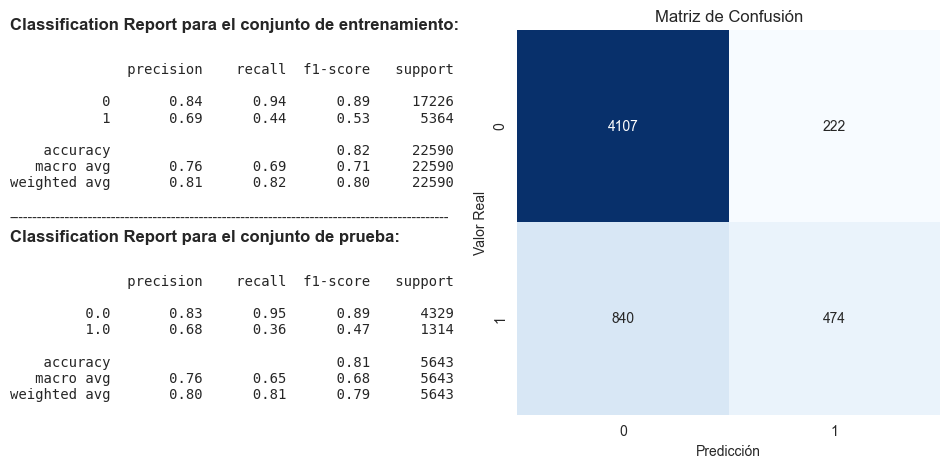

<Figure size 400x300 with 0 Axes>

In [39]:
logistic_model1 = LogisticRegression(random_state=42)
logistic_model1.fit(X_train, y_train_clasification)

# Hacer predicciones
y_pred_train = logistic_model1.predict(X_train)
y_pred_test = logistic_model1.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Mostrar el cuadro de texto (classification report) para el conjunto de entrenamiento
ax1.text(0, 1, "Classification Report para el conjunto de entrenamiento:", fontsize=12, weight='bold')
ax1.text(0, 0.55, classification_report(y_train_clasification, y_pred_train), fontsize=10, family='monospace')
ax1.axis('off')

# Añadir una pequeña separación vertical
ax1.text(0, 0.5, "-" * 95, fontsize=10)

# Mostrar el cuadro de texto (classification report) para el conjunto de prueba
ax1.text(0, 0.45, "Classification Report para el conjunto de prueba:", fontsize=12, weight='bold')
ax1.text(0, 0, classification_report(y_test_clasification, y_pred_test), fontsize=10, family='monospace')

ax1.axis('off')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_clasification, y_pred_test)
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax2)
ax2.set_xlabel('Predicción')
ax2.set_ylabel('Valor Real')
ax2.set_title('Matriz de Confusión')
plt.tight_layout()
plt.show()

## Regresión logística con penalización por clases

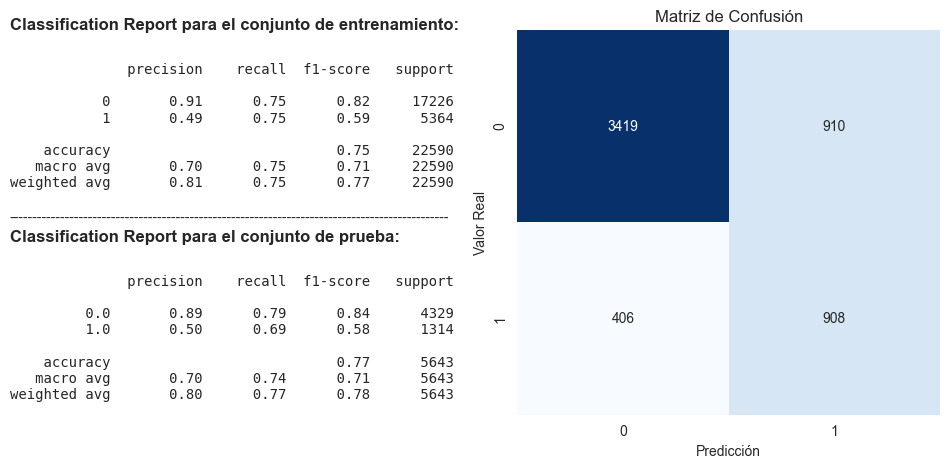

<Figure size 400x300 with 0 Axes>

In [40]:
logistic_model2 = LogisticRegression(random_state=42, class_weight='balanced')
logistic_model2.fit(X_train, y_train_clasification)

# Hacer predicciones
y_pred_train = logistic_model2.predict(X_train)
y_pred_test = logistic_model2.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Mostrar el cuadro de texto (classification report) para el conjunto de entrenamiento
ax1.text(0, 1, "Classification Report para el conjunto de entrenamiento:", fontsize=12, weight='bold')
ax1.text(0, 0.55, classification_report(y_train_clasification, y_pred_train), fontsize=10, family='monospace')
ax1.axis('off')

# Añadir una pequeña separación vertical
ax1.text(0, 0.5, "-" * 95, fontsize=10)

# Mostrar el cuadro de texto (classification report) para el conjunto de prueba
ax1.text(0, 0.45, "Classification Report para el conjunto de prueba:", fontsize=12, weight='bold')
ax1.text(0, 0, classification_report(y_test_clasification, y_pred_test), fontsize=10, family='monospace')

ax1.axis('off')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_clasification, y_pred_test)
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax2)
ax2.set_xlabel('Predicción')
ax2.set_ylabel('Valor Real')
ax2.set_title('Matriz de Confusión')
plt.tight_layout()
plt.show()

## Regresión logística con balanceo de clases SMOTE

In [41]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_clasification)

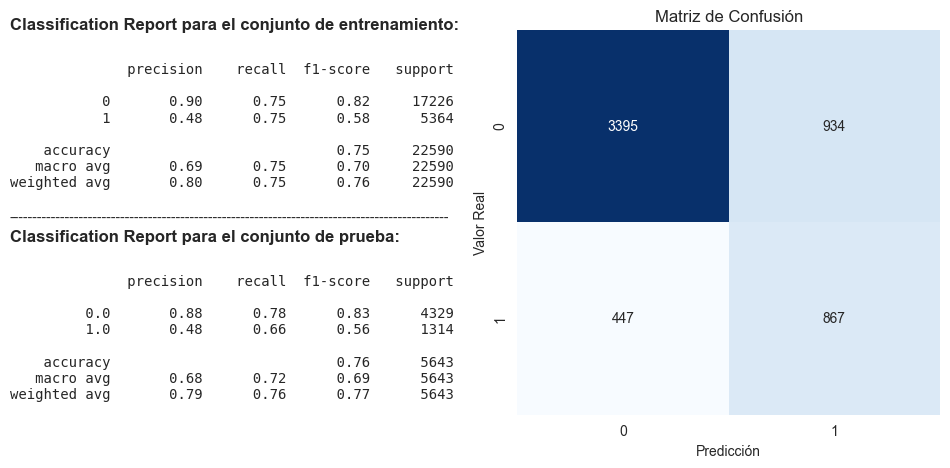

<Figure size 400x300 with 0 Axes>

In [42]:
logistic_model3 = LogisticRegression(random_state=42)
logistic_model3.fit(X_train_resampled, y_train_resampled)

# Hacer predicciones
y_pred_train = logistic_model3.predict(X_train)
y_pred_test = logistic_model3.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Mostrar el cuadro de texto (classification report) para el conjunto de entrenamiento
ax1.text(0, 1, "Classification Report para el conjunto de entrenamiento:", fontsize=12, weight='bold')
ax1.text(0, 0.55, classification_report(y_train_clasification, y_pred_train), fontsize=10, family='monospace')
ax1.axis('off')

# Añadir una pequeña separación vertical
ax1.text(0, 0.5, "-" * 95, fontsize=10)

# Mostrar el cuadro de texto (classification report) para el conjunto de prueba
ax1.text(0, 0.45, "Classification Report para el conjunto de prueba:", fontsize=12, weight='bold')
ax1.text(0, 0, classification_report(y_test_clasification, y_pred_test), fontsize=10, family='monospace')

ax1.axis('off')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_clasification, y_pred_test)
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax2)
ax2.set_xlabel('Predicción')
ax2.set_ylabel('Valor Real')
ax2.set_title('Matriz de Confusión')
plt.tight_layout()
plt.show()

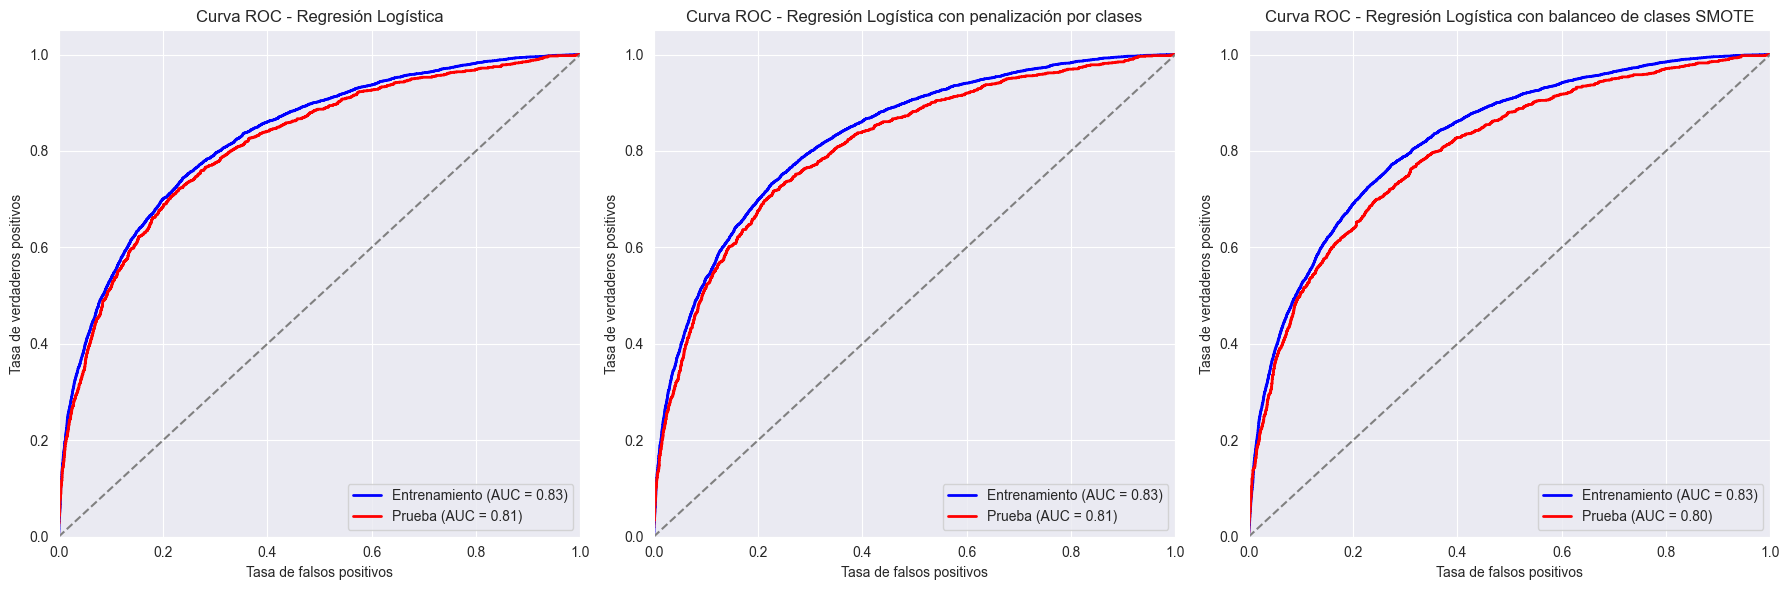

In [43]:
# Obtener las probabilidades de predicción de la clase positiva para entrenamiento y prueba para cada modelo
y_pred_proba_train1 = logistic_model1.predict_proba(X_train)[:, 1]
y_pred_proba_test1 = logistic_model1.predict_proba(X_test)[:, 1]

y_pred_proba_train2 = logistic_model2.predict_proba(X_train)[:, 1]
y_pred_proba_test2 = logistic_model2.predict_proba(X_test)[:, 1]

y_pred_proba_train3 = logistic_model3.predict_proba(X_train)[:, 1]
y_pred_proba_test3 = logistic_model3.predict_proba(X_test)[:, 1]

# Calcular la curva ROC para entrenamiento y prueba para cada modelo
fpr_train1, tpr_train1, _ = roc_curve(y_train_clasification, y_pred_proba_train1)
fpr_test1, tpr_test1, _ = roc_curve(y_test_clasification, y_pred_proba_test1)
auc_train1 = roc_auc_score(y_train_clasification, y_pred_proba_train1)
auc_test1 = roc_auc_score(y_test_clasification, y_pred_proba_test1)

fpr_train2, tpr_train2, _ = roc_curve(y_train_clasification, y_pred_proba_train2)
fpr_test2, tpr_test2, _ = roc_curve(y_test_clasification, y_pred_proba_test2)
auc_train2 = roc_auc_score(y_train_clasification, y_pred_proba_train2)
auc_test2 = roc_auc_score(y_test_clasification, y_pred_proba_test2)

fpr_train3, tpr_train3, _ = roc_curve(y_train_clasification, y_pred_proba_train3)
fpr_test3, tpr_test3, _ = roc_curve(y_test_clasification, y_pred_proba_test3)
auc_train3 = roc_auc_score(y_train_clasification, y_pred_proba_train3)
auc_test3 = roc_auc_score(y_test_clasification, y_pred_proba_test3)

# Trazar las curvas ROC para entrenamiento y prueba para cada modelo en una sola fila
plt.figure(figsize=(18, 6))

# Modelo 1
plt.subplot(1, 3, 1)
plt.plot(fpr_train1, tpr_train1, color='blue', lw=2, label='Entrenamiento (AUC = %0.2f)' % auc_train1)
plt.plot(fpr_test1, tpr_test1, color='red', lw=2, label='Prueba (AUC = %0.2f)' % auc_test1)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc='lower right')

# Modelo 2
plt.subplot(1, 3, 2)
plt.plot(fpr_train2, tpr_train2, color='blue', lw=2, label='Entrenamiento (AUC = %0.2f)' % auc_train2)
plt.plot(fpr_test2, tpr_test2, color='red', lw=2, label='Prueba (AUC = %0.2f)' % auc_test2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC - Regresión Logística con penalización por clases')
plt.legend(loc='lower right')

# Modelo 3
plt.subplot(1, 3, 3)
plt.plot(fpr_train3, tpr_train3, color='blue', lw=2, label='Entrenamiento (AUC = %0.2f)' % auc_train3)
plt.plot(fpr_test3, tpr_test3, color='red', lw=2, label='Prueba (AUC = %0.2f)' % auc_test3)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC - Regresión Logística con balanceo de clases SMOTE')
plt.legend(loc='lower right')

# Ajustar espaciado entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

### Podemos notar que al aplicar el método de sobre muestreo SMOTE o la regresión logística con penalización a la clase minoritaria podemos notar una mejora en los valores de recall

## Modelo Clasificar base 

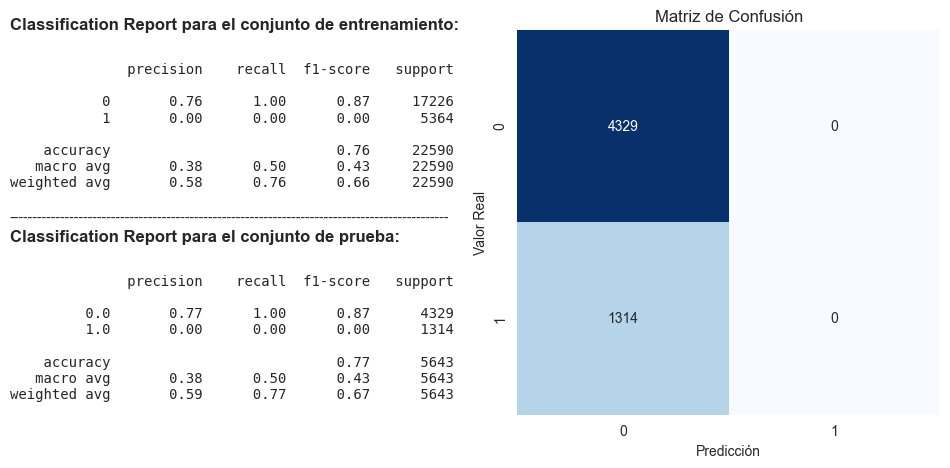

<Figure size 400x300 with 0 Axes>

In [44]:
# Crear el clasificador ingenuo que predice la clase mayoritaria
naive_classifier = DummyClassifier(strategy="most_frequent")

# Entrenar el modelo con los datos de entrenamiento
naive_classifier.fit(X_train, y_train_clasification)

# Hacer predicciones sobre los datos de entrenamiento y prueba
y_pred_train = naive_classifier.predict(X_train)
y_pred_test = naive_classifier.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Mostrar el cuadro de texto (classification report) para el conjunto de entrenamiento
ax1.text(0, 1, "Classification Report para el conjunto de entrenamiento:", fontsize=12, weight='bold')
ax1.text(0, 0.55, classification_report(y_train_clasification, y_pred_train), fontsize=10, family='monospace')
ax1.axis('off')

# Añadir una pequeña separación vertical
ax1.text(0, 0.5, "-" * 95, fontsize=10)

# Mostrar el cuadro de texto (classification report) para el conjunto de prueba
ax1.text(0, 0.45, "Classification Report para el conjunto de prueba:", fontsize=12, weight='bold')
ax1.text(0, 0, classification_report(y_test_clasification, y_pred_test), fontsize=10, family='monospace')
ax1.axis('off')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_clasification, y_pred_test)
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax2)
ax2.set_xlabel('Predicción')
ax2.set_ylabel('Valor Real')
ax2.set_title('Matriz de Confusión')
plt.tight_layout()
plt.show()

## curva ROC de modelo base

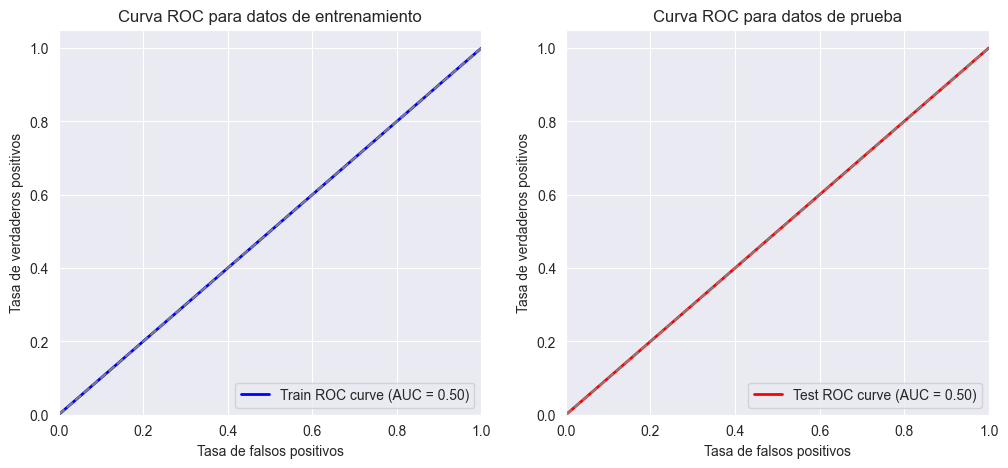

In [45]:
# Obtener las probabilidades de predicción de la clase positiva (la clase mayoritaria)
y_pred_proba_train = np.full_like(y_train_clasification, fill_value=1)  # Clase mayoritaria
y_pred_proba_test = np.full_like(y_test_clasification, fill_value=1)  # Clase mayoritaria

# Calcular la curva ROC para los datos de entrenamiento y prueba
fpr_train, tpr_train, _ = roc_curve(y_train_clasification, y_pred_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test_clasification, y_pred_proba_test)

# Calcular el área bajo la curva ROC (AUC) para los datos de entrenamiento y prueba
auc_train = roc_auc_score(y_train_clasification, y_pred_proba_train)
auc_test = roc_auc_score(y_test_clasification, y_pred_proba_test)

# Crear la figura con dos subplots uno al lado del otro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Trazar la curva ROC para los datos de entrenamiento
ax1.plot(fpr_train, tpr_train, color='blue', lw=2, label='Train ROC curve (AUC = %0.2f)' % auc_train)
ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('Tasa de falsos positivos')
ax1.set_ylabel('Tasa de verdaderos positivos')
ax1.set_title('Curva ROC para datos de entrenamiento')
ax1.legend(loc='lower right')

# Trazar la curva ROC para los datos de prueba
ax2.plot(fpr_test, tpr_test, color='red', lw=2, label='Test ROC curve (AUC = %0.2f)' % auc_test)
ax2.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Tasa de falsos positivos')
ax2.set_ylabel('Tasa de verdaderos positivos')
ax2.set_title('Curva ROC para datos de prueba')
ax2.legend(loc='lower right')

# Mostrar la figura
plt.show()


## Modelo Regresion base 

In [46]:
# Crear un DummyRegressor que predice la media de la variable objetivo
dummy_regressor = DummyRegressor(strategy='mean')

# Entrenar el modelo de regresión base con los datos de entrenamiento
dummy_regressor.fit(X_train, y_train)

# Hacer predicciones con el modelo de regresión base en los datos de entrenamiento y prueba
y_pred_train_base = dummy_regressor.predict(X_train)
y_pred_test_base = dummy_regressor.predict(X_test)

# Calcular el error cuadrático medio (MSE) del modelo de regresión base para el conjunto de entrenamiento y prueba
mse_train_base = mean_squared_error(y_train, y_pred_train_base)
mse_test_base = mean_squared_error(y_test, y_pred_test_base)

# Calcular el Error Absoluto Medio (MAE) para el conjunto de entrenamiento y prueba
mae_train_base = mean_absolute_error(y_train, y_pred_train_base)
mae_test_base = mean_absolute_error(y_test, y_pred_test_base)

# Calcular el Error Porcentual Absoluto Medio (MAPE) para el conjunto de prueba
mape_test_base = np.mean(np.abs((y_test - y_pred_test_base) / y_test)) * 100

# Calcular el coeficiente de determinación (R-cuadrado) para el conjunto de prueba
r2_test_base = r2_score(y_test, y_pred_test_base)

# Imprimir las métricas
print("Métricas para el modelo de regresión base:")
print("Error cuadrático medio (MSE) (Train):", mse_train_base)
print("Error cuadrático medio (MSE) (Test):", mse_test_base)
print("Mean Absolute Error (MAE) (Train):", mae_train_base)
print("Mean Absolute Error (MAE) (Test):", mae_test_base)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test_base)
print("R-squared (Test):", r2_test_base)


Métricas para el modelo de regresión base:
Error cuadrático medio (MSE) (Train): 39.33047103465534
Error cuadrático medio (MSE) (Test): 44.68189308133037
Mean Absolute Error (MAE) (Train): 2.995796672637569
Mean Absolute Error (MAE) (Test): 3.1453231475225363
Mean Absolute Percentage Error (MAPE) (Test): inf
R-squared (Test): -0.00041781852103839334
